[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fonnesbeck/bayes_course_june_2024/blob/master/notebooks/Section2-PyMC_Intro.ipynb)

# Building Models in PyMC

Now that we have been introduced to PyMC at a very high level, let's now take a more detailed look at PyMC's API as it relates to building models.

## PyTensor

Before we dive into building Bayesian models in PyMC, we want to give a brief introduction to the PyTensor library. PyTensor is a Python library that allows you to define, optimize/rewrite, and evaluate mathematical expressions involving multi-dimensional arrays efficiently. It serves as the computational backend of PyMC.

![pytensor logo](images/PyTensor_RGB.png)

Some of PyTensor’s features are:

- Tight integration with NumPy - Use `numpy.ndarray` in PyTensor-compiled functions
- Efficient symbolic differentiation - PyTensor efficiently computes your derivatives for functions with one or many inputs
- Speed and stability optimizations - Get the right answer for log(1 + x) even when x is near zero
- Dynamic C/JAX/Numba code generation - Evaluate expressions faster

PyTensor is based on Theano, which has been powering large-scale computationally intensive scientific investigations since 2007.

### A simple example

To begin, we define some pytensor tensors and show how to perform some basic operations.

In [ ]:
import pytensor
import pytensor.tensor as pt
import numpy as np

x = pt.scalar(name="x")
y = pt.vector(name="y")

print(
    f"""
x type: {x.type}
x name = {x.name}
---
y type: {y.type}
y name = {y.name}
"""
)

Now that we have defined the `x` and `y` tensors, we can create a new one by adding them together.

In [ ]:
z = x + y
z.name = "x + y"

To make the computation a bit more complex let us take the logarithm of the resulting tensor.

In [ ]:
w = pt.log(z)
w.name = "log(x + y)"

We can use the `pytensor.dprint` function to print the computational graph of any given tensor.

In [ ]:
pytensor.dprint(w)

Note that this graph does not do any computation (yet!). It is simply defining the sequence of steps to be done. We can use `pytensor.function` to define a callable object so that we can push values trough the graph.

In [ ]:
f = pytensor.function(inputs=[x, y], outputs=w)

Now that the graph is compiled, we can push some concrete values:

In [ ]:
f(x=0, y=[1, np.e])

> TIP:
> Sometimes we just want to debug, we can use `pytensor.graph.basic.Variable.eval` for that:

In [ ]:
w.eval({x: 0, y: [1, np.e]})

You can set intermediate values as well

In [ ]:
w.eval({z: [1, np.e]})

### Graph optimization

One of the most important features of `pytensor` is that it can automatically optimize the mathematical operations inside a graph. Let's consider a simple example:

In [ ]:
a = pt.scalar(name="a")
b = pt.scalar(name="b")

c = a / b
c.name = "a / b"

pytensor.dprint(c)

Now let us multiply `b` times `c`. This should result in simply `a`.

In [ ]:
d = b * c
d.name = "b * c"

pytensor.dprint(d)

The graph shows the full computation, but once we compile it the operation becomes the identity on `a` as expected.

In [ ]:
g = pytensor.function(inputs=[a, b], outputs=d)

pytensor.dprint(g)

### What is in an PyTensor graph?

The following diagram shows the basic structure of an `pytensor` graph.

![pytensor graph](images/apply.png)

We can can make these concepts more tangible by explicitly indicating them in the first example from the section above. Let us compute the graph components for the tensor `z`. 

In [ ]:
print(
    f"""
z type: {z.type}
z name = {z.name}
z owner = {z.owner}
z owner inputs = {z.owner.inputs}
z owner op = {z.owner.op}
z owner output = {z.owner.outputs}
"""
)


z type: Vector(float64, shape=(?,))
z name = x + y
z owner = Add(ExpandDims{axis=0}.0, y)
z owner inputs = [ExpandDims{axis=0}.0, y]
z owner op = Add
z owner output = [x + y]



### Example: Logistic regression

Here is a non-trivial example, which uses PyTensor to estimate the parameters of a logistic regression model using gradient information. We will use a bioassay example as a test case.

Gelman et al. (2003) present an example of an acute toxicity test, commonly performed on animals to estimate the toxicity of various compounds.

In this dataset `log_dose` includes 4 levels of dosage, on the log scale, each administered to 5 rats during the experiment. The response variable is `death`, the number of positive responses to the dosage.

The number of deaths can be modeled as a binomial response, with the probability of death being a linear function of dose:

$$\begin{aligned}
y_i &\sim \text{Bin}(n_i, p_i) \\
\text{logit}(p_i) &= a + b x_i
\end{aligned}$$

The common statistic of interest in such experiments is the **LD50**, the dosage at which the probability of death is 50%.

In [ ]:
import numpy as np

rng = np.random

dose = np.array([-0.86, -0.3 , -0.05,  0.73])
deaths = np.array([0, 1, 3, 5])
training_steps = 1000

First, let's declare our symbolic variables.

This code introduces a few new concepts. The `shared` function constructs so-called shared variables. These are hybrid symbolic and non-symbolic variables whose value may be shared between multiple functions. Shared variables can be used in symbolic expressions just like the objects returned by `dmatrices` but they also have an internal value that defines the value taken by this symbolic variable in all the functions that use it. It is called a shared variable because its value is shared between many functions. The value can be accessed and modified by the `get_value()` and `set_value()` methods

In [ ]:
X = pt.vector("X")
Y = pt.vector("Y")
b = pytensor.shared(1., name="b")
a = pytensor.shared(0., name="a")

print("Initial model:", a.get_value(), b.get_value())

Initial model: 0.0 1.0


... then construct the expression graph:

In [ ]:
# Probability that target = 1
p_1 = 1 / (1 + pt.exp(-(a +X*b))) 

# The prediction threshold
prediction = p_1 > 0.5         

# Cross-entropy loss function
xent = -Y * pt.log(p_1) - (5-Y) * pt.log(1-p_1) 

# The cost to minimize
cost = xent.mean()      

# Compute the gradient of the cost
ga, gb = pt.grad(cost, [a, b])                  

Compile PyTensor functions for training the model and predicting from it.

In [ ]:
step = pytensor.shared(10., name='step')
train = pytensor.function(
          inputs=[X, Y],
          outputs=[prediction, xent],
          updates=((a, a - step * ga), (b, b - step * gb), (step, step * 0.99)),
)
predict = pytensor.function(inputs=[X], outputs=prediction)

Now we can train the model!

In [ ]:
for i in range(training_steps):
    pred, err = train(dose, deaths)
    
a_value, b_value = a.get_value(), b.get_value()

print("Final model:", a_value, b_value)

Final model: 0.8536420249683847 7.795152457538434


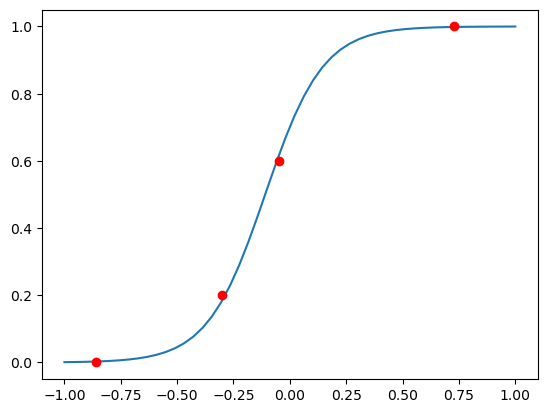

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

logit = lambda x: 1. / (1 + np.exp(-x))
xvals = np.linspace(-1, 1)
plt.plot(xvals, logit(b_value*xvals + a_value))
plt.plot(dose, deaths/5., 'ro')

### Graph manipulation 101

Another interesting feature of PyTensor is the ability to manipulate the computational graph, something that is not possible with TensorFlow or PyTorch. Here we continue with the example above in order to illustrate the main idea around this technique.

In [ ]:
# get input tensors
list(pytensor.graph.graph_inputs(graphs=[w]))

[x, y]

As a simple example, let's add an `pytensor.tensor.exp` before the `pytensor.tensor.log` (to get the identity function).

In [ ]:
parent_of_w = w.owner.inputs[0]  # get z tensor
new_parent_of_w = pt.exp(parent_of_w)  # modify the parent of w
new_parent_of_w.name = "exp(x + y)"

Note that the graph of `w` has actually not changed:

In [ ]:
pytensor.dprint(w)

Log [id A] 'log(x + y)'
 └─ Add [id B] 'x + y'
    ├─ ExpandDims{axis=0} [id C]
    │  └─ x [id D]
    └─ y [id E]


To modify the graph we need to use the `pytensor.clone_replace` function, which *returns a copy of the initial subgraph with the corresponding substitutions.*

In [ ]:
new_w = pytensor.clone_replace(output=[w], replace={parent_of_w: new_parent_of_w})[0]
new_w.name = "log(exp(x + y))"
pytensor.dprint(new_w)

Log [id A] 'log(exp(x + y))'
 └─ Exp [id B] 'exp(x + y)'
    └─ Add [id C] 'x + y'
       ├─ ExpandDims{axis=0} [id D]
       │  └─ x [id E]
       └─ y [id F]


Finally, we can test the modified graph by passing some input to the new graph.

In [ ]:
new_w.eval({x: 0, y: [1, np.e]})

array([1.        , 2.71828183])

As expected, the new graph is just the identity function.

> NOTE:
> Again, note that `pytensor` is clever enough to omit the `exp` and `log` once we compile the function.

In [ ]:
f = pytensor.function(inputs=[x, y], outputs=new_w)

pytensor.dprint(f)

Add [id A] 'x + y' 1
 ├─ ExpandDims{axis=0} [id B] 0
 │  └─ x [id C]
 └─ y [id D]


In [ ]:
f(x=0, y=[1, np.e])

array([1.        , 2.71828183])

## PyMC Variable Classes

Bayesian inference begins with specification of a probability model relating unknown variables to data. PyMC provides the basic building blocks for Bayesian probability models: stochastic random variables, deterministic variables, and factor potentials. 

A **stochastic random variable** is a factor whose value is not completely determined by its parents, while the value of a **deterministic random variable** is entirely determined by its parents. Most models can be constructed using only these two variable types. The third quantity, the **factor potential**, is *not* a variable but simply a
log-likelihood term or constraint that is added to the joint log-probability to modify it. 

### The Distribution class

A stochastic variable is represented in PyMC by a `Distribution` class. This structure adds functionality to Pytensor's `pytensor.tensor.random.op.RandomVariable` class, mainly by registering it with an associated PyMC `Model`. As we demonstrated in a previous section, `Distribution` objects are only usable inside of a `Model` context.

`Distribution` subclasses (i.e. implementations of specific statistical distributions) will accept several arguments when constructed:

`name`
:   Name for the new model variable. This argument is **required**, and is used as a label and index value for the variable.

`shape`
:   The variable's shape.

`total_size`
:   The overall size of the variable (this variable will not exist for scalars).

`dims`
:   A tuple of dimension names known to the model.

`transform`
:   A transformation to be applied to the distribution when used by the model, especially when the distribution is constrained.

`initval`
:   Numeric or symbolic untransformed initial value of matching shape, or one of the following initial value strategies: "moment", "prior". Depending on the sampler's settings, a random jitter may be added to numeric, symbolic or moment-based initial values in the transformed space.

`model`
:   The PyMC model to which the variable belongs.


As we previewed in the introduction, `Distribution` has a classmethod `dist` that returns a **stateless** probability distribution of that type; that is, without being wrapped in a PyMC random variable object. Sometimes we wish to use a particular statistical distribution, without using it as a variable in a model; for example, to generate random numbers from the distribution. 

In [ ]:
import seaborn as sns
import pymc as pm
import arviz as az

x = pm.Exponential.dist(1)
samples = pm.draw(x, draws=1000)
sns.histplot(samples);

## Motivating Example: Educational Outcomes for Hearing-impaired Children

To demonstrate the PyMC API in-depth, we will use a dataset of educational outcomes for children with hearing impairment. Here, we are interested in determining factors that are associated with better or poorer learning outcomes. 

This anonomized dataset is taken from the Listening and Spoken Language Data Repository (LSL-DR), an international data repository that tracks the demographics and longitudinal outcomes for children who have hearing loss and are enrolled programs focused on supporting listening and spoken language development. Researchers are interesting in discovering factors related to improvements in educational outcomes at within these programs.

There is a suite of available predictors, including: 

* gender (`male`)
* number of siblings in the household (`siblings`)
* index of family involvement (`family_inv`)
* whether the primary household language is not English (`non_english`)
* presence of a previous disability (`prev_disab`)
* non-white race (`non_white`)
* age at the time of testing (in months, `age_test`)
* whether hearing loss is not severe (`non_severe_hl`)
* whether the subject's mother obtained a high school diploma or better (`mother_hs`)
* whether the hearing impairment was identified by 3 months of age (`early_ident`).

The outcome variable is a standardized test score in one of several learning domains.

In [ ]:
import polars as pl

test_scores = pl.read_csv(pm.get_data("test_scores.csv"))
test_scores.head()

In [ ]:
test_scores["score"].plot.hist()

In [ ]:
# Dropping missing values is a very bad idea in general, but we do so here for simplicity
test_scores = test_scores.drop_nulls().cast(pl.Float32)
y = test_scores["score"]
# Standardize the features
X = test_scores.drop("score").select((pl.all()-pl.all().mean()) / pl.all().std())

N, D = X.shape

### The Model

This is a **multivariate regression** model, which takes the form:

$$\begin{aligned} 
Y  &\sim \mathcal{N}(\mu, \sigma^2) \\
\mu &= \beta_0 + X \beta
\end{aligned}$$

where $X$ is a matrix of predictors and $\beta$ a vector of coefficients.

However, while there are several potential predictors in the LSL-DR dataset, it is difficult *a priori* to determine which ones are relevant for constructing an effective statistical model. There are a number of approaches for conducting variable selection, but a popular automated method is *regularization*, whereby ineffective covariates are shrunk towards zero via regularization (a form of penalization) if they do not contribute to predicting outcomes. 

You may have heard of regularization from machine learning or classical statistics applications, where methods like the lasso or ridge regression shrink parameters towards zero by applying a penalty to the size of the regression parameters. In a Bayesian context, we apply an appropriate prior distribution to the regression coefficients. One such prior is the *hierarchical regularized horseshoe*, which uses two regularization strategies, one global and a set of local local parameters, one for each coefficient. The key to making this work is by selecting a long-tailed distribution as the shrinkage prior, which allows some to be nonzero, while pushing the rest towards zero.

The horeshoe prior for each regression coefficient $\beta_i$ looks like this:

$$\beta_i \sim N\left(0, \tau^2 \cdot \tilde{\lambda}_i^2\right)$$

where $\sigma$ is the prior on the error standard deviation that will also be used for the model likelihood.

Where $\tau$ is the global shrinkage parameter and $\tilde{\lambda}_i$ is the local. Let's start global: for the prior on $\tau$ we will use a Half-StudentT distribution, which is a reasonable choice becuase it is heavy-tailed.

$$
\tau \sim \textrm{Half-StudentT}_{2} \left(\frac{D_0}{D - D_0} \cdot \frac{\sigma}{\sqrt{N}}\right).
$$

One catch is that the parameterization of the prior requires a pre-specified value $D_0$, which represents the true number of non-zero coefficients. Fortunately, a reasonable guess at this value is all that is required, and it need only be within an order of magnitude of the true number. Let's use half the number of predictors as our guess:

In [ ]:
D0 = int(D / 2)
D0

Meanwhile, the local shrinkage parameters are defined by the ratio:

$$\tilde{\lambda}_i^2 = \frac{c^2 \lambda_i^2}{c^2 + \tau^2 \lambda_i^2}.$$

To complete this specification, we need priors on $\lambda_i$ and $c$;  as with the global shrinkage, we use a long-tailed $\textrm{Half-StudentT}_5(1)$  on the $\lambda_i$. We need $c^2$ to be strictly positive, but not necessarily long-tailed, so an inverse gamma prior on $c^2$, $c^2 \sim \textrm{InverseGamma}(1, 1)$ fits the bill.


### Creation of stochastic random variables

Stochastic random variables with standard distributions provided by PyMC can be created in a single line using special subclasses of the `Distribution` class. 

This model employs a couple of new distributions: the `HalfStudentT` distribution for the $\tau$ and $\lambda$ priors, and the `InverseGamma` distribution for the $c2$ variable.

We are also going to take advantage of **named dimensions** in PyMC by passing the input variable names into the model as coordinates called "predictors". This will allow us to pass this vector of names as a replacement for the `shape` integer argument in the vector-valued parameters. The model will then associate the appropriate name with each latent parameter that it is estimating. This is a little more work to set up, but will pay dividends later when we are working with our model output.

In [ ]:
X.columns

In [ ]:
with pm.Model(coords={"predictors": X.columns}) as test_score_model:

    # Prior on error SD
    sigma = pm.HalfNormal("sigma", 25)
    
    # Global shrinkage prior
    tau = pm.HalfStudentT("tau", 2, D0 / (D - D0) * sigma / np.sqrt(N))
    # Local shrinkage prior
    lam = pm.HalfStudentT("lam", 2, dims="predictors")
    c2 = pm.InverseGamma("c2", 1, 0.1)

## Model Contexts and Random Variables

As we have seen, the canonical way to specify PyMC models is using a `Model` context manager. Generally speaking, a context manager is a Python idiom that does the following:

```python
    VAR = EXPR
    VAR.__enter__()
    try:
        USERCODE
    finally:
        VAR.__exit__()

```

As an analogy, `Model` is a tape machine that records what is being added to the model; it keeps track the random variables (observed or unobserved) and other model components. The model context then computes some simple model properties, builds a **bijection** mapping that transforms between Python dictionaries and numpy/Pytensor ndarrays. , More importantly, a `Model` contains methods to compile Pytensor functions that take Random Variables--that are also
initialised within the same model--as input.

Within a model context, random variables are essentially Pytensor `TensorVariables`:

```python
with pm.Model() as model:
    z = pm.Normal('z', mu=0., sigma=5.)             # ==> pytensor.tensor.var.TensorVariable
    x = pm.Normal('x', mu=z, sigma=1., observed=5.) # ==> pytensor.tensor.var.TensorVariable
pm.logp(z, 2.5).eval()                              # ==> -2.65337645
model.compile_logp()({'z': 2.5})                    # ==> -6.6973152

```

PyMC includes most of the probability density functions (for continuous variables) and probability mass functions (for discrete variables) used in statistical modeling. These distributions are divided into five distinct categories:

* Univariate continuous
* Univariate discrete
* Multivariate
* Mixture
* Timeseries

Probability distributions are all subclasses of `Distribution`, which in turn has two major subclasses: `Discrete` and `Continuous`. In terms of data types, a `Continuous` random variable is given whichever floating point type is defined by `pytensor.config.floatX`, while `Discrete` variables are given `int16` types when `pytensor.config.floatX` is `float32`, and `int64` otherwise.

In [ ]:
sigma.dtype

Multivariate and Timeseries random variables are vector-valued, rather than scalar (though `Continuous` and `Discrete` variables may have non-scalar values).

In [ ]:
sigma.shape.eval()

In [ ]:
lam.shape.eval()

All of the `Distribution` subclasses included in PyMC will have two key methods, `random()` and `logp()`, which are used to generate random values and compute the log-probability of a value, respectively.

```python
class SomeDistribution(Continuous):
    def __init__(...):
        ...

    def random(self, point=None, size=None):
        ...
        return random_samples

    def logp(self, value):
        ...
        return total_log_prob
```

PyMC expects the `logp()` method to return a log-probability evaluated at the passed `value` argument. This method is used internally by all of the inference methods to calculate the model log-probability that is used for fitting models. The `random()` method is used to simulate values from the variable, and is used internally for posterior predictive checks.

Distributions will optionally have `cdf` and `icdf` methods, representing the cumulative distribution function and inverse cumulative distribution functions, respectively.

If you have a well-behaved density function, we can use it in a model to build a model log-likelihood function. Almost any Pytensor function can be turned into a
distribution using the `CustomDist` function. For exmaple, a uniformly-distributed discrete stochastic variable could be created manually from a function that computes its log-probability as follows:

In [ ]:
with pm.Model():
    
    def uniform_logp(value, lower, upper):
        return pm.math.switch((value > upper) | (value < lower), -np.inf, -pm.math.log(upper - lower + 1))

    u = pm.CustomDist('u', 0, 10, logp=uniform_logp, dtype='int64')

In [ ]:
pm.logp(u, 6).eval()

Passing values outside the support of the distribution to `logp()` will return `-inf`, since the value has no probability. 

In [ ]:
pm.logp(u, -4).eval()

A couple of things to notice: while the function specified for the `logp` argument can be an arbitrary Python function, it must use **Pytensor operators and functions** in its body. This is because one or more of the arguments passed to the function may be `TensorVariables`, and they must be supported. 

To emphasize, the Python function passed to `CustomDist` should compute the *log*-density or *log*-probability of the variable. That is why the return value in the example above is `-log(upper-lower+1)` rather than `1/(upper-lower+1)`.

### Auto-transformation

To support efficient sampling by PyMC's MCMC algorithms, any continuous variables that are constrained to a sub-interval of the real line are automatically transformed so that their support is unconstrained. This frees sampling algorithms from having to deal with boundary constraints.

For example, if we look at the variables we have create in the test score model so far:

In [ ]:
test_score_model.value_vars

The model's `value_vars` attribute stores the values of each random variable actually used by the model's log-likelihood.

As the name suggests, the variables `sigma`, `tau`, `lam`, and `c2` have been log-transformed, and this is the space over which posterior sampling takes place. When a sample is drawn, the value of the transformed variable is simply back-transformed to recover the original variable.

By default, auto-transformed variables are ignored when summarizing and plotting model output, since they are not generally of interest to the user.

Returning to our model specification, the intercept will not be subject to regularization, and will be given a normal distribution centered on the population mean:

In [ ]:
with test_score_model:
    beta0 = pm.Normal("beta0", 100, 25)

## Deterministic Variables

A deterministic variable is one whose values are **completely determined** by the values of their parents.

In [ ]:
with test_score_model:

    shrinkage_sd = tau * lam * pm.math.sqrt(c2 / (c2 + tau**2 * lam**2))

    beta = pm.Normal('beta', 0, shrinkage_sd, dims='predictors')

so `shrinkage_sd`'s value can be computed exactly from the values of its parents `tau`, `lam` and `c2`.

There are two types of deterministic variables in PyMC:

#### Anonymous deterministic variables

The easiest way to create a deterministic variable is to operate on or transform one or more variables in a model directly, as we have done above for `shrinkage_sd`.

These are called *anonymous* variables because we did not wrap it with a call to `Determinstic`, which gives it a name as its first argument. We simply specified the variable as a Python (or, Pytensor) expression. This is therefore the simplest way to construct a determinstic variable. The only caveat is that the values generated by anonymous determinstics at every iteration of a MCMC algorithm, for example, are not recorded to the resulting trace. So, this approach is only appropriate for intermediate values in your model that you do not wish to obtain posterior estimates for, alongside the other variables in the model.

#### Named deterministic variables

To ensure that deterministic variables' values are accumulated during sampling, they should be instantiated using the **named deterministic** interface; this uses the `Deterministic` function to create the variable. Two things happen when a variable is created this way:

1. The variable is given a name (passed as the first argument)
2. The variable is appended to the model's list of random variables, which ensures that its values are tallied.

If we wanted named variabels for the shrinkage standard deviation, we would have specified:

```python
shrinkage_sd = pm.Deterministic('shrinkage_sd', tau * lam * pm.math.sqrt(c2 / (c2 + tau**2 * lam**2)))
```

## Observed Random Variables

Stochastic random variables whose values are observed (*i.e.* data likelihoods) are represented by a different class than unobserved random variables. A `ObservedRV` object is instantiated any time a stochastic variable is specified with data passed as the `observed` argument. 

In [ ]:
with test_score_model:
    
    scores = pm.Normal("scores", beta0 + X.to_numpy() @ beta, sigma, observed=y.to_numpy())

In [ ]:
pm.model_to_graphviz(test_score_model)

An important responsibility of `ObservedRV` is to automatically handle missing values in the data, when they are present (absent?). More on this later.

## Factor Potentials

For some applications, we want to be able to modify the joint density by incorporating terms that don't correspond to probabilities of variables conditional on parents. For example, suppose in the coal mining disasters model we want to constrain the difference between the early and late means to be less than 1, so that the joint density becomes: 

$$p(y,\tau,\lambda_1,\lambda_2) \propto p(y|\tau,\lambda_1,\lambda_2) p(\tau) p(\lambda_1) p(\lambda_2) I(|\lambda_2-\lambda_1| \lt 1)$$

We call such log-probability terms **factor potentials** (Jordan 2004). Bayesian
hierarchical notation doesn't accomodate these potentials. 

### Creation of Potentials

A potential can be created via the `Potential` function, in a way very similar to `Deterministic`'s named interface:

```python
with disaster_model:
    
    rate_constraint = pm.Potential('rate_constraint', pm.math.switch(pm.math.abs(early_mean-late_mean)>1, -np.inf, 0))
```

The function takes just a `name` as its first argument and an expression returning the appropriate log-probability as the second argument.

A common use of a factor potential is to represent an observed likelihood, where the **observations are partly a function of model variables**. In the contrived example below, we are representing the error in a linear regression model as a zero-mean normal random variable. Thus, the "data" in this scenario is the residual, which is a function both of the data and the regression parameters. 

If we represent this as a standard likelihood function (a `Distribution` with an `observed` keyword argument), we run into problems. This parameterization would not be compatible with an observed stochastic, because the `err` term would become fixed in the likelihood and not be allowed to change during sampling.

In [ ]:
y_vals = np.array([15, 10, 16, 11, 9, 11, 10, 18, 11])
x_vals = np.array([1, 2, 4, 5, 6, 8, 19, 18, 12])

with pm.Model() as regression:

    sigma = pm.HalfCauchy('sigma', 5)
    beta = pm.Normal('beta', 0, sigma=2)
    mu = pm.Normal('mu', 0, sigma=10)

    err = y_vals - (mu + beta*x_vals)
                  
    like = pm.Normal('like', 0, sigma=sigma, observed=err)

Instead, we can re-express the likelihood as a factor potential, which is a function of the data and the model parameters. 

In [ ]:
with pm.Model() as regression:

    sigma = pm.HalfCauchy('sigma', 5)
    beta = pm.Normal('beta', 0, sigma=2)
    mu = pm.Normal('mu', 0, sigma=10)

    err = y_vals - (mu + beta*x_vals)
                  
    like = pm.Potential('like', 
        pm.logp(
            pm.Normal.dist(0, sigma=sigma), 
            err
        )
    )

## Exercise: Bioassay model

Gelman et al. (2003) present an example of an acute toxicity test, commonly performed on animals to estimate the toxicity of various compounds.

In this dataset `log_dose` includes 4 levels of dosage, on the log scale, each administered to 5 rats during the experiment. The response variable is death, the number of positive responses to the dosage.

The number of deaths can be modeled as a binomial response, with the probability of death being a linear function of dose:

$$\begin{aligned}
y_i &\sim \text{Bin}(n_i, p_i) \\
\text{logit}(p_i) &= a + b x_i
\end{aligned}$$

The common statistic of interest in such experiments is the LD50, the dosage at which the probability of death is 50%.

Specify this model in PyMC:

In [ ]:
# Log dose in each group
log_dose = [-.86, -.3, -.05, .73]

# Sample size in each group
n = 5

# Outcomes
deaths = [0, 1, 3, 5]

In [ ]:
# Write model here

---

## References

1. Ching & Chen. 2007. Transitional Markov chain Monte Carlo method for Bayesian model updating, model class selection and model averaging. Journal of Engineering Mechanics 2007
2.	Hoffman MD, Gelman A. 2014. The No-U-turn sampler: adaptively setting path lengths in Hamiltonian Monte Carlo. The Journal of Machine Learning Research. 15(1):1593-1623.
3. M.I. Jordan. 2004. Graphical models. Statist. Sci., 19(1):140–155.
4. Neal, R. M. 2003. Slice sampling. The Annals of Statistics, 31(3), 705–767. doi:10.1111/1467-9868.00198